Experimenting with the data from EnerjıSA Datathon using recurrent neural networks.

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler

# Preprocessing

In [2]:
generation_source=pd.read_csv('data/generation.csv', sep=';', decimal=',', parse_dates=True)
generation_nandrop=generation_source.dropna()

temperature_source=pd.read_csv('data/temperature.csv', sep=';', decimal=',', parse_dates=True)
temperature_nandrop=temperature_source.drop(temperature_source.tail(95).index)

merged=temperature_nandrop.merge(generation_nandrop, on='DateTime', how='left')

merged['DateTime']=pd.to_datetime(merged['DateTime'])

#Thanks to other partipiciant's work I know exactly how to deal with this feature (reference link at the end of the notebook)
merged['WWCode']=merged['WWCode'].fillna(0)
merged['WWCode']=merged['WWCode'].replace([84], 83)

#saving copies
datetime_copy=merged['DateTime']
merged_with_dt_as_column=merged
merged=merged.set_index('DateTime')
merged.index.freq='H'

# normalizing
merged['WindDirection']=merged['WindDirection']/10
merged['WWCode']=merged['WWCode']/10

merged

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Generation
DateTime,,,,,,,,
2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,6.0,1.0,6.3,0.000000
2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,7.0,1.0,4.5,0.000000
2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,8.0,1.0,5.5,0.000008
2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,6.0,1.0,7.6,0.000000
2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,6.0,1.0,6.5,0.000008
...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,8.9,8.4,62.0,0.0,0.0,0.2,1.5,NaN
2021-12-31 20:00:00,8.0,7.6,65.9,0.0,0.0,0.2,1.5,NaN
2021-12-31 21:00:00,7.3,6.9,70.1,0.0,0.0,0.6,1.5,NaN


<AxesSubplot:xlabel='DateTime'>

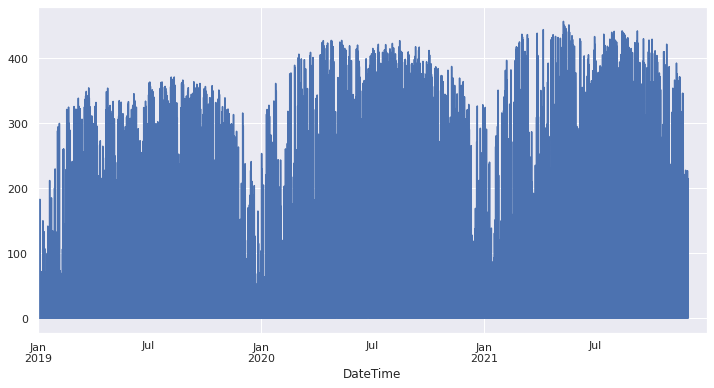

In [3]:
merged['Generation'].plot(figsize=(12,6))

# The model

In [28]:
#training data
df_for_training=merged.drop(merged.tail(31*24).index)

# hyperparameters
LEARNING_RATE=1e-3
DECAY=1e-5
MAX_EPOCHS=200
BATCH_SIZE=32
VALID_SPLIT=0.2
PATIENCE=10

n_future=1*24
n_past=1*24

scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

#creating the required shape for LSTM network (samples (rows), timesteps, features (columns))
trainX=[]
trainY=[]

for i in range(n_past, len(df_for_training_scaled)-n_future+1):
    
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

trainX, trainY=np.array(trainX), np.array(trainY)

#model architecture
model=Sequential()

model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1))

#optimizing and training
opt=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay=DECAY)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
early_stopping=tf.keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)

history=model.fit(trainX, trainY,
        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT,
                 callbacks=[early_stopping], verbose=1)

Epoch 1/200
638/638 [==============================] - 12s 13ms/step - loss: 0.1516 - mse: 0.1516 - val_loss: 0.0294 - val_mse: 0.0294
Epoch 2/200
638/638 [==============================] - 8s 12ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 3/200
638/638 [==============================] - 7s 12ms/step - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 4/200
638/638 [==============================] - 7s 11ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 5/200
638/638 [==============================] - 8s 12ms/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6/200
638/638 [==============================] - 7s 12ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 7/200
638/638 [==============================] - 7s 11ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 8/200
638/638 [==============================] - 8s 12m

Minimum Validation Loss: 0.0079


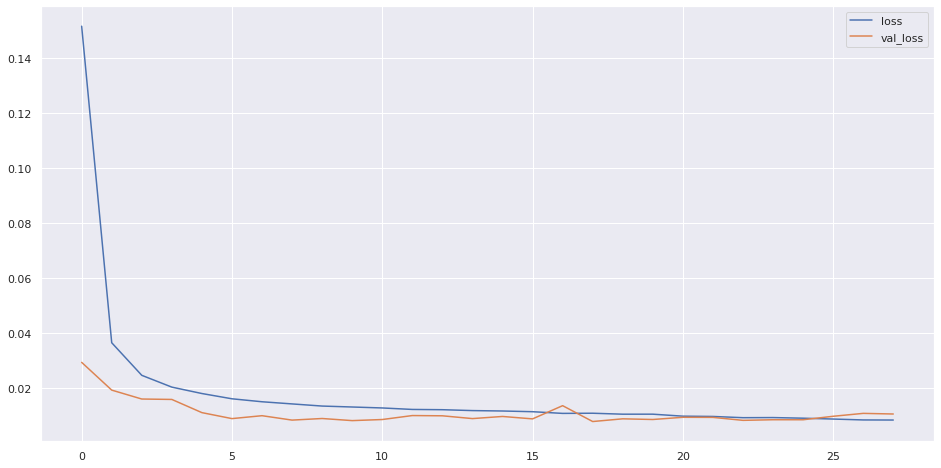

In [29]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(figsize=(16,8))
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

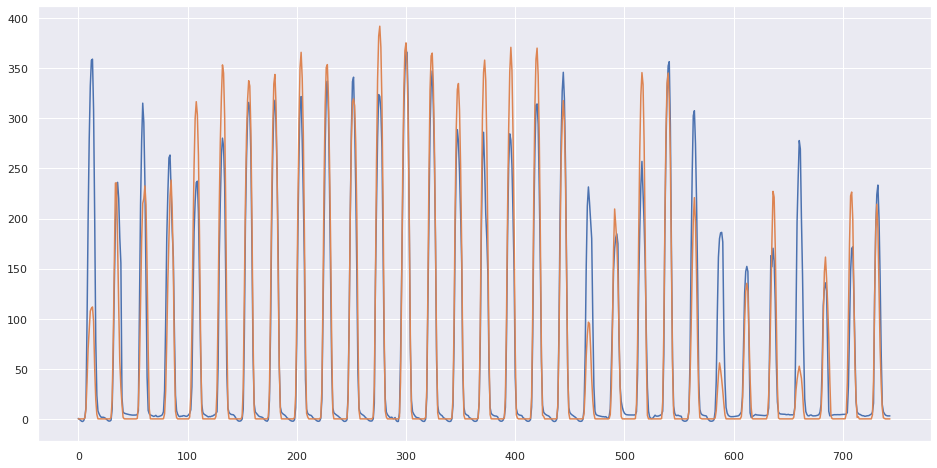

41.56291077519682

In [62]:
f = scaler.inverse_transform(forecast_copies)[:,-1]
a = df_for_training.tail(31*24).Generation.values
plt.figure(figsize=(16,8))
plt.plot(f)
plt.plot(a)
plt.show()

from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(a,f))

# Predicting

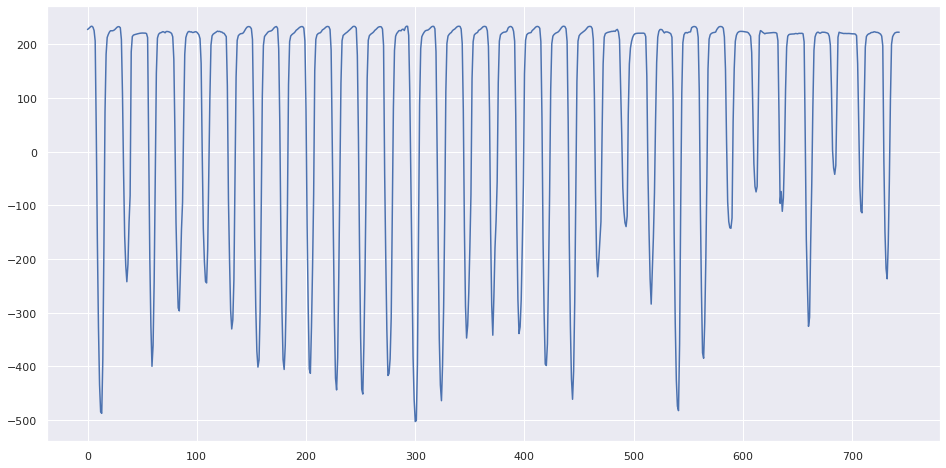

In [30]:
n_hours_for_prediction=24*31 

forecast=model.predict(trainX[-n_hours_for_prediction:])

forecast_copies=np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0]

k=df_for_training.Generation.mean()/y_pred_future.mean()
y_pred_future=k*y_pred_future
plt.figure(figsize=(16,8))
plt.plot(y_pred_future)

# A note
If you have recommendations, I would love to hear them.

## References  
Dealing with WWCode: https://www.kaggle.com/mohres/data-preprocessing-cleaning  
Overall process: https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py